In [1]:
import ceo
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

/home/ubuntu/CEO/python/ceo/zemax


# Broadband PSF image
Create a broadband PSF image.

In [2]:
# ----- Initialize telescope
gmt = ceo.GMT_MX()
D = 25.5                # [m] Diameter of simulated square (slightly larger than GMT diameter) 
gmt.M2_baffle = 3.5     # Circular diameter pupil mask obscuration
gmt.project_truss_onaxis = True
nPx = 512

In [3]:
# ---- Initialize guide star
gs = ceo.Source('K', zenith=0.,azimuth=0., rays_box_size=D, 
        rays_box_sampling=nPx, rays_origin=[0.0,0.0,25])

In [4]:
# ----- Retrieve pupil mask
gmt.reset()
gs.reset()
gmt.propagate(gs)
maskPup = gs.amplitude.host()

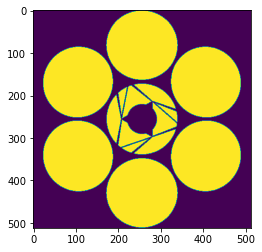

In [5]:
plt.imshow(maskPup)

In [6]:
#------------------- Function to show PSF
#   im_display_size: +/- mas from center
def show_psf(myPSF, im_display_size=150, clim=[-8,0], fig=None,ax1=None):
    if ax1==None:
        fig, ax1 = plt.subplots()
        fig.set_size_inches(7,5)
        fig.dpi=100
        
    im_range_mas = np.array([-im_display_size, im_display_size])
    im_range_pix = np.rint(im_range_mas/bbpsf._fp_pxscl_mas + bbpsf._im_sz/2).astype(int)

    imm = ax1.imshow(np.log10(myPSF[im_range_pix[0]:im_range_pix[1],im_range_pix[0]:im_range_pix[1]]), 
                     extent=[-im_display_size,im_display_size,-im_display_size,im_display_size], 
                     origin='lower', interpolation='None')
    clb = fig.colorbar(imm, ax=ax1)
    imm.set_clim(clim)
    ax1.set_xlabel('mas')

## Option 1
Select band, and assume *top-hat* transmission

In [7]:
#-- Option 1. Select band, and assume top-hat transmission
Ks_band = [1.990e-6, 2.29e-6]
bbpsf = ceo.BBPSF(maskPup, wvl_band=Ks_band, wvl_res=10e-9, D=D, fov_mas=4000)

Central filter wavelength 2.139 um


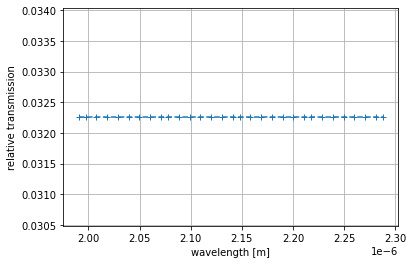

In [8]:
plt.plot(bbpsf._wvlall, bbpsf._spectral_flux.get(), '+--')
plt.xlabel('wavelength [m]')
plt.ylabel('relative transmission')
plt.grid()

cwvl = np.mean(bbpsf._wvlall)
print('Central filter wavelength %0.3f um'%(cwvl*1e6))

In [9]:
%%time

#------ Diffraction-limited PSF
psf_dl = bbpsf.propagate(np.zeros((nPx,nPx)))

CPU times: user 224 ms, sys: 144 ms, total: 368 ms
Wall time: 368 ms


In [10]:
#---- The image is returned with unitary flux value
sum_psf_dl = cp.sum(psf_dl)
max_psf_dl = cp.max(psf_dl)
sum_psf_dl, max_psf_dl

(array(0.99362662), array(0.09677728))

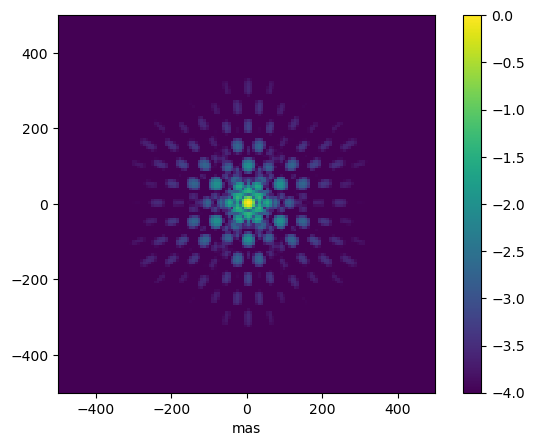

In [11]:
show_psf((psf_dl/cp.max(psf_dl)).get(), im_display_size=500, clim=[-4,0])

## Option 2
Select a predefined filter. Currently, filters supported are the ones in the arte library:
https://arte.readthedocs.io/en/latest/photometry.html#module-arte.photometry.filters

In [12]:
#-- Option 2. Select a specific filter and use its transmission vs wavelength curve
bbpsf = ceo.BBPSF(maskPup, filter_type='johnson_k', wvl_res=10e-9, D=D, fov_mas=4000)

Central filter wavelength 2.204 um


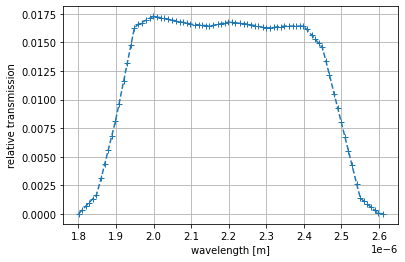

In [13]:
plt.plot(bbpsf._wvlall, bbpsf._spectral_flux.get(), '+--')
plt.xlabel('wavelength [m]')
plt.ylabel('relative transmission')
plt.grid()

cwvl = np.mean(bbpsf._wvlall)
print('Central filter wavelength %0.3f um'%(cwvl*1e6))

In [14]:
%%time

#------ Diffraction-limited PSF
psf_dl = bbpsf.propagate(np.zeros((nPx,nPx)))

CPU times: user 120 ms, sys: 44 ms, total: 164 ms
Wall time: 162 ms


In [15]:
#---- The image is returned with unitary flux value
sum_psf_dl = cp.sum(psf_dl)
max_psf_dl = cp.max(psf_dl)
sum_psf_dl, max_psf_dl

(array(0.99341412), array(0.07632213))

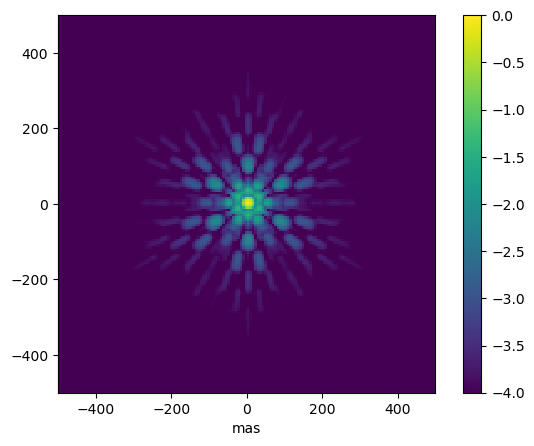

In [16]:
show_psf((psf_dl/cp.max(psf_dl)).get(), im_display_size=500, clim=[-4,0])

## Option 3
Select a predefined filter, but used only a narrower band.

In [17]:
#-- Option 3. 
Ks_band = [1.990e-6, 2.29e-6]
bbpsf = ceo.BBPSF(maskPup, filter_type='johnson_k', wvl_band=Ks_band, wvl_res=10e-9, D=D, fov_mas=4000)

Central filter wavelength 2.139 um


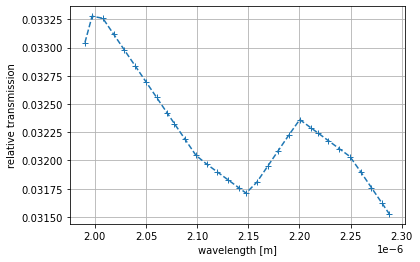

In [18]:
plt.plot(bbpsf._wvlall, bbpsf._spectral_flux.get(), '+--')
plt.xlabel('wavelength [m]')
plt.ylabel('relative transmission')
plt.grid()

cwvl = np.mean(bbpsf._wvlall)
print('Central filter wavelength %0.3f um'%(cwvl*1e6))

In [19]:
%%time

#------ Diffraction-limited PSF
psf_dl = bbpsf.propagate(np.zeros((nPx,nPx)))

CPU times: user 36 ms, sys: 16 ms, total: 52 ms
Wall time: 48.9 ms


In [20]:
#---- The image is returned with unitary flux value
sum_psf_dl = cp.sum(psf_dl)
max_psf_dl = cp.max(psf_dl)
sum_psf_dl, max_psf_dl

(array(0.9936306), array(0.0968759))

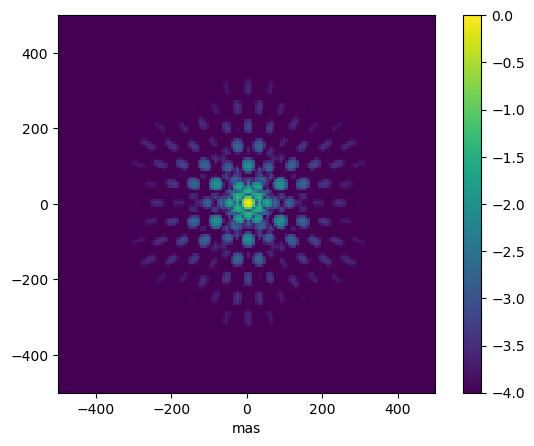

In [21]:
show_psf((psf_dl/cp.max(psf_dl)).get(), im_display_size=500, clim=[-4,0])

# PSF computation method 1
You can pass a phase map to the *propagate()* method. It uses the *maskPup* array as the amplitude of the electric field.

In [22]:
Ks_band = [1.990e-6, 2.29e-6]
bbpsf = ceo.BBPSF(maskPup, filter_type='johnson_k', wvl_band=Ks_band, wvl_res=10e-9, D=D, fov_mas=4000)
psf_dl = bbpsf.propagate(np.zeros((nPx,nPx)))
sum_psf_dl = cp.sum(psf_dl)
max_psf_dl = cp.max(psf_dl)

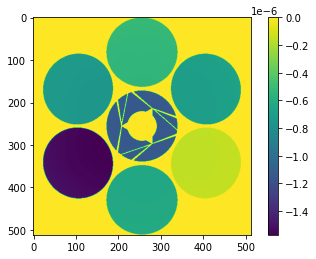

In [23]:
gmt.reset()
gs.reset()
gmt.M1.motion_CS.origin[:,2] = np.random.random(7) * 1e-6
gmt.M1.motion_CS.update()
gmt.propagate(gs)
phase = gs.phase.host()

plt.imshow(phase)
plt.colorbar()

In [24]:
#------  PSF with WF aberrations
psf = bbpsf.propagate(phase)

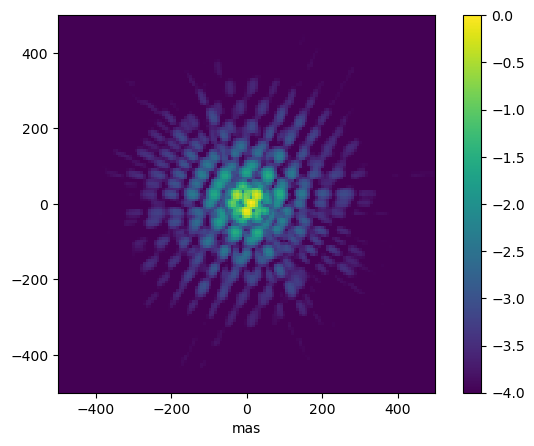

In [25]:
show_psf((psf/cp.max(psf)).get(), im_display_size=500, clim=[-4,0])

In [26]:
# SR estimation
SR = cp.max(psf) / max_psf_dl
print('SR of broadband PSF: %0.3f'%SR)

SR of broadband PSF: 0.355


# PSF computation method 2
To avoid transfering data from the GPU to CPU, and then back to the GPU, you can run the *calibrate* method to create
a reference to the *source* amplitude and phase arrays in the GPU memory. 

There is no need to pass a phase map to the propagate method. It will retrieve it internally from the *source* (gs) object.

In [27]:
gmt.reset()
gs.reset()
gmt.propagate(gs)

In [28]:
Ks_band = [1.990e-6, 2.29e-6]
bbpsf = ceo.BBPSF(gs.amplitude.host(), filter_type='johnson_k', wvl_band=Ks_band, wvl_res=10e-9, D=D, fov_mas=4000)
bbpsf.calibrate(gs)

In [29]:
# --- diffraction-limited psf
psf_dl = bbpsf.propagate()
sum_psf_dl = cp.sum(psf_dl)
max_psf_dl = cp.max(psf_dl)

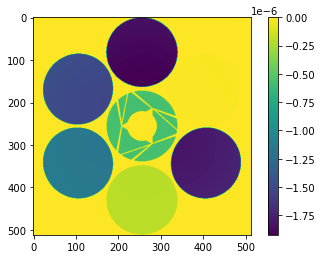

In [30]:
# --- Introduce WF aberrations
gmt.reset()
gs.reset()
gmt.M1.motion_CS.origin[:,2] = np.random.random(7) * 1e-6
gmt.M1.motion_CS.update()
gmt.propagate(gs)

plt.imshow(gs.phase.host())
plt.colorbar()

In [31]:
#------  PSF with WF aberrations
psf = bbpsf.propagate()

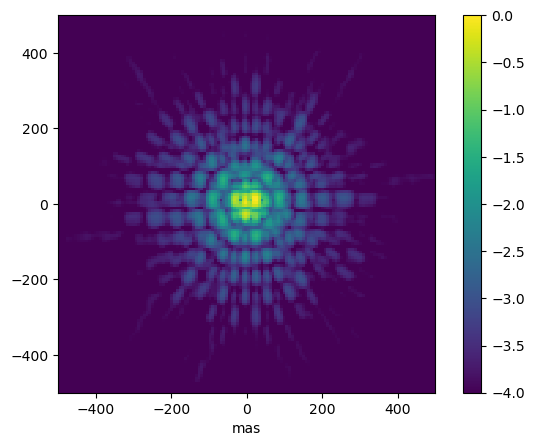

In [32]:
show_psf((psf/cp.max(psf)).get(), im_display_size=500, clim=[-4,0])

In [33]:
# SR estimation
SR = cp.max(psf) / max_psf_dl
print('SR of broadband PSF: %0.3f'%SR)

SR of broadband PSF: 0.294


In [ ]:
#